In [ ]:
import kagglehub

# download dataset from kaggle via kagglehub api
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

c:\Users\TYC\Desktop\python code\satellite_road_seg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.76G/5.76G [05:04<00:00, 20.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\TYC\.cache\kagglehub\datasets\balraj98\massachusetts-roads-dataset\versions\1


In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


In [2]:
#path
image_dir = "./MA_road_data/tiff/test"
mask_dir = "./MA_road_data/tiff/test_labels"

#make list of files
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

print(f"Number of images: {len(image_files)}")
print(f"Number of masks: {len(mask_files)}")

Number of images: 49
Number of masks: 49


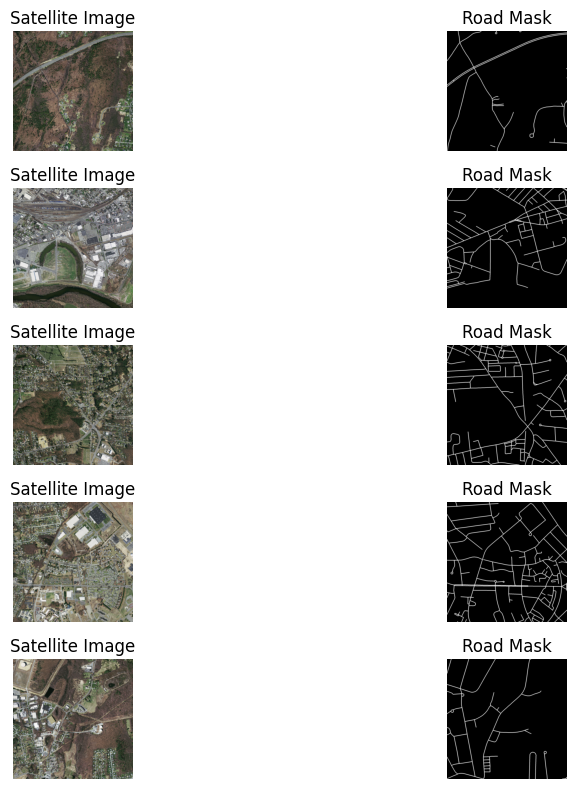

In [3]:
#pick first 5 images and masks to display

plt.figure(figsize=(12,8))
for i, idx in enumerate(range(5)):

    img_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])

    image=Image.open(img_path)
    mask=Image.open(mask_path)

    #plot image
    plt.subplot(5, 2, i*2+1)
    plt.imshow(image)
    plt.title("Satellite Image")
    plt.axis('off')

    #plot mask
    plt.subplot(5, 2, i*2+2)
    plt.imshow(mask, cmap='gray')
    plt.title("Road Mask")  
    plt.axis('off')

plt.tight_layout()
plt.show()

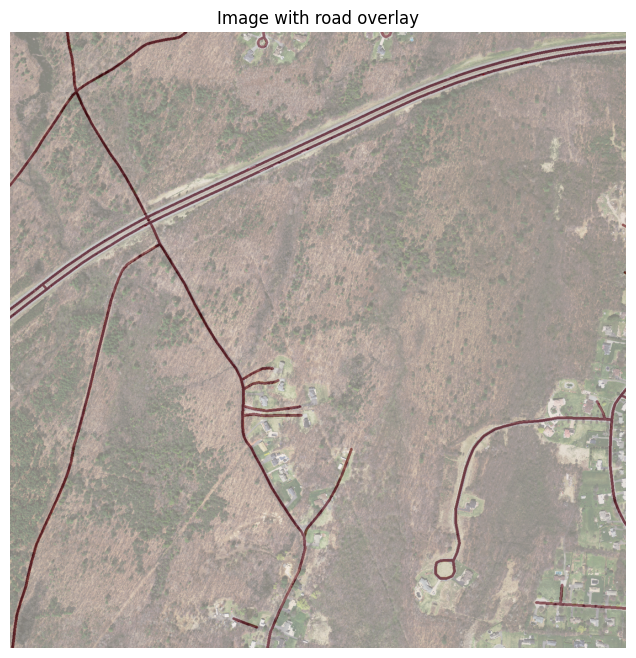

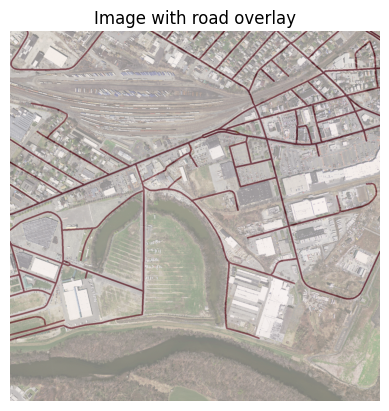

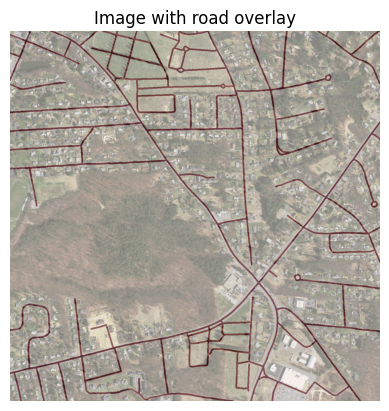

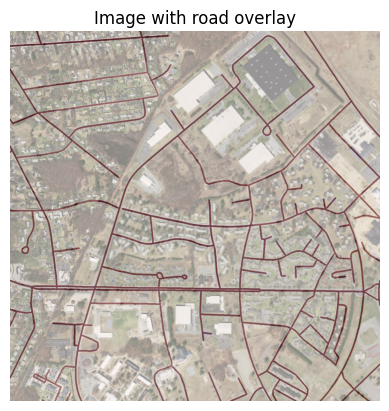

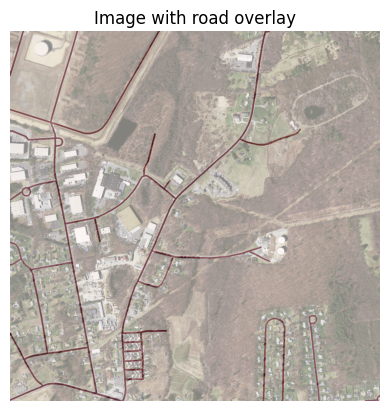

In [4]:
#overlay mask on image

plt.figure(figsize=(12,8))
for i, idx in enumerate(range(5)):

    img_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])

    image=Image.open(img_path)
    mask=Image.open(mask_path)

    plt.imshow(image)
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.title("Image with road overlay")
    plt.axis('off')
    plt.show()  

In [5]:
#declare a class for the dataset to be used in dataloader

class RoadDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") #grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        #convert mask to binary
        mask = (mask > 0).float()

        return image, mask


In [6]:
#resize into smaller size for faster training and normalise to [0,1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [30]:
#path
train_image_dir = "./MA_road_data/tiff/train"
train_mask_dir = "./MA_road_data/tiff/train_labels"
val_image_dir = "./MA_road_data/tiff/val"
val_mask_dir = "./MA_road_data/tiff/val_labels"

#create dataset
train_dataset = RoadDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = RoadDataset(val_image_dir, val_mask_dir, transform=transform)

#dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#check batch for train loader
images, masks = next(iter(train_loader))
print(f"Image batch shape: {images.size()}")
print(f"Mask batch shape: {masks.size()}")

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


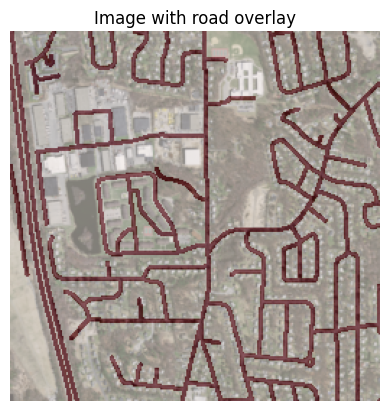

In [31]:
#display an image with mask overlay
img = images[1].permute(1, 2, 0).numpy() #CHW to HWC
mask = masks[1].squeeze().numpy() #CHW to HW

plt.imshow(img)
plt.imshow(mask, cmap='Reds', alpha=0.5)
plt.title("Image with road overlay")
plt.axis('off')
plt.show()

In [32]:
#define a convolution block

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)



In [33]:
### MODEL ARCHITECTURE (U-NET) ###

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        #encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)

        #bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        #decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 =ConvBlock(128, 64)

        #output
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):

        #encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        #bottleneck
        b = self.bottleneck(self.pool(e4))

        #decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        #output
        out = self.conv_final(d1)

        return torch.sigmoid(out) #binary segmentation

In [34]:
#testing 
test_model = UNet(in_channels=3, out_channels=1)

x = torch.randn(1, 3, 256, 256)
y = test_model(x)

print(y.shape)

torch.Size([1, 1, 256, 256])


In [35]:
#define dice loss
def dice_loss(pred, target, smooth=1.):

    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))

    return loss.mean()

In [36]:
#loss function as the combination of BCE and Dice loss

class BCEDiceLoss(nn.Module):

    def __init__(self, weight_dice=0.5):
        super().__init__()
        
        self.bce = nn.BCELoss()
        self.weight_dice = weight_dice

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        d_loss = dice_loss(pred, target)
        
        return bce_loss + self.weight_dice * d_loss

In [38]:
#training loop

def train_unet(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):

    model = model.to(device)
    criterion = BCEDiceLoss()
    optimizer = optim.AdamW(model.parameter(), lr=lr)
    print("Current device:" , device)

    best_val_loss = float('inf') #infinity

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            #compute loss
            loss = criterion(outputs, masks)
            loss.backwards()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        #validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, masks in val_loader:

                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /=len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        #save the best model
        if val_loss < best_val_loss:
            
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_road_seg_unet.pth")
            print("Best model saved")

In [ ]:
#### WARNING: TRAINING EXECUTION PHASE COMPUTATIONALLY INTENSIVE ####

#create model
model = UNet(in_channels = 3,  out_channels = 1)

#train
train_unet(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu')